In [1]:
import sys
from utils import print_json
from utils.cloudant_utils import cloudant_db as db, save_doc
from datetime import date
import numpy as np
import pandas as pd

SUCCESS connecting to Cloudant db github-public-ai-2022


In [2]:
repos = [r for r in db.get_query_result({"type": "release"}, ["_id", "releases"], 
                                        limit=10000, raw_result=True)["docs"]]
repos[0]['releases'][0].keys()

dict_keys(['repo', 'release_tag', 'release_date', 'downloads', 'stars', 'watchers', 'forks', 'commits', 'issues', 'total_stars', 'total_forks', 'total_commits', 'contributors', 'total_issues', 'total_closedIssues', 'closedIssues', 'readme', 'readme_size'])

In [3]:
values = [r for release in repos for r in release["releases"]]
df = pd.DataFrame(values)
df.shape 

(44043, 19)

# clean the data 

In [4]:
# df['contributors'] = df['contributors'].apply(lambda d: d if isinstance(d, list) else [])
# df['contributors'] = df['contributors'].apply(lambda x: [i for i in x if i is not None] )
df['contributors'] = df['contributors'].apply(lambda x: 
                                              [i for i in x if i is not None] if isinstance(x, list)
                                              else [])

In [5]:
# df['contributors'].str.len()
# new_df['contributor_count'] = new_df['contributors'].apply(lambda x: len(x))
# df['contributor_count'] = df.contributors.map(len)

# Make a copy of Original dataframe

In [6]:
new_df = df[['repo', 'release_tag', 'release_date', 'downloads', 'stars', 'forks', 'commits', 
             'issues', 'closedIssues', 'readme', 'readme_size', 'contributors']].copy()

In [7]:
new_df.nlargest(n=5, columns=['stars'])

,repo,release_tag,release_date,downloads,stars,forks,commits,issues,closedIssues,readme,readme_size,contributors
24495,iperov/DeepFaceLab,DF.wf.288res.384.92.72.22,2020-04-09T05:48:48Z,66151,18517,4013,355,0,0,"﻿<table align=""center"" border=""0""><tr><td alig...",6462,[iperov]
9974,TencentARC/GFPGAN,v0.2.0,2021-08-06T12:07:49Z,93903,16450,2451,44,108,40,# GFPGAN (CVPR 2021)\n\n[![download](https://i...,5668,[xinntao]
11537,ageitgey/face_recognition,v1.2.2,2018-04-02T17:18:43Z,0,13956,4107,61,0,0,# Face Recognition\n\nRecognize and manipulate...,17036,"[mtrsk, timgates42, ariyapour, snyk-bot, ageit..."
17558,deepfakes/faceswap,v2.0.0,2020-08-14T17:28:01Z,354765,9274,2034,386,0,0,"# deepfakes_faceswap\n<p align=""center"">\n <a...",12719,"[torzdf, daniellivingston, geewiz94]"
14359,babysor/MockingBird,v0.0.1,2021-11-07T13:53:53Z,0,8939,1544,52,0,0,![mockingbird](https://user-images.githubuserc...,9198,"[XiuChen-Liu, hertz-pj, oceanarium, babysor]"


In [8]:
corrrelation= new_df.corr(method="pearson")
print("Pearson correlation coefficient:")
print(corrrelation)

Pearson correlation coefficient:
              downloads     stars     forks   commits    issues  closedIssues  \
downloads      1.000000  0.043922  0.043820  0.014488 -0.002087     -0.002513   
stars          0.043922  1.000000  0.816321  0.195501  0.122044      0.093542   
forks          0.043820  0.816321  1.000000  0.194977  0.059695      0.043666   
commits        0.014488  0.195501  0.194977  1.000000  0.241782      0.243473   
issues        -0.002087  0.122044  0.059695  0.241782  1.000000      0.908576   
closedIssues  -0.002513  0.093542  0.043666  0.243473  0.908576      1.000000   
readme_size   -0.006683  0.079201  0.049521  0.067220  0.050490      0.050327   

              readme_size  
downloads       -0.006683  
stars            0.079201  
forks            0.049521  
commits          0.067220  
issues           0.050490  
closedIssues     0.050327  
readme_size      1.000000  


# REPO basis Analysis

In [9]:
# df[df["repo"]=="10up/classifai"]

In [10]:
repo_df = new_df.groupby('repo').agg(
        forks=pd.NamedAgg(column="forks", aggfunc="sum"),
        downloads=pd.NamedAgg(column="downloads", aggfunc="sum"),
        stars=pd.NamedAgg(column="stars", aggfunc="sum"),
        release_counts=pd.NamedAgg(column="release_tag", aggfunc="count"),
        commits=pd.NamedAgg(column="commits", aggfunc="sum"),
        issues=pd.NamedAgg(column="issues", aggfunc="sum"),
        closedIssues=pd.NamedAgg(column="closedIssues", aggfunc="sum"),
        contributors=pd.NamedAgg(column="contributors", aggfunc="sum"),
        readme = pd.NamedAgg(column="readme_size", aggfunc="last")
    )
repo_df

,forks,downloads,stars,release_counts,commits,issues,closedIssues,contributors,readme
repo,,,,,,,,,
0xangelo/raylab,6,0,46,1,1183,1,1,"[0xangelo, dependabot-preview[bot]]",0
100/Solid,9,0,60,2,0,1,0,[],2098
10up/classifai,34,0,219,11,655,65,52,"[dinhtungdu, jeffpaul, johnwatkins0, helen, je...",11711
1adrianb/face-alignment,443,0,2225,10,84,0,0,"[1adrianb, imadtoubal, bdvllrs, 1adrianb, jkle...",5612
1adrianb/pytorch-estimate-flops,0,0,123,8,37,6,5,"[1adrianb, 1adrianb, 1adrianb, 1adrianb, 1adri...",2189
...,...,...,...,...,...,...,...,...,...
zycv/Speaker-Recognition-Based-on-Deep-Learning-An-Overview,1,53,11,2,0,0,0,[zycv],16786
zyddnys/manga-image-translator,47,1782,207,4,211,32,22,"[zyddnys, zyddnys, zyddnys, tr7zw, QiroNT, rsp...",8932
zyfra/ebonite,9,0,66,16,147,4,1,"[mike0sv, i-a-andrianov, mike0sv, i-a-andriano...",0


# Release basis Analysis

In [11]:
repo_df['contributors'] = repo_df['contributors'].apply(set)

In [12]:
repo_df['contributor_count'] = repo_df['contributors'].map(len)

In [13]:
repo_df

,forks,downloads,stars,release_counts,commits,issues,closedIssues,contributors,readme,contributor_count
repo,,,,,,,,,,
0xangelo/raylab,6,0,46,1,1183,1,1,"{0xangelo, dependabot-preview[bot]}",0,2
100/Solid,9,0,60,2,0,1,0,{},2098,0
10up/classifai,34,0,219,11,655,65,52,"{phpbits, dinhtungdu, s3rgiosan, ActuallyConno...",11711,17
1adrianb/face-alignment,443,0,2225,10,84,0,0,"{bdvllrs, Serega6678, 1adrianb, kstanleyadams,...",5612,8
1adrianb/pytorch-estimate-flops,0,0,123,8,37,6,5,"{senysenyseny16, 1adrianb}",2189,2
...,...,...,...,...,...,...,...,...,...,...
zycv/Speaker-Recognition-Based-on-Deep-Learning-An-Overview,1,53,11,2,0,0,0,{zycv},16786,1
zyddnys/manga-image-translator,47,1782,207,4,211,32,22,"{zyddnys, tr7zw, QiroNT, kdrkdrkdr, rspreet92,...",8932,8
zyfra/ebonite,9,0,66,16,147,4,1,"{mike0sv, i-a-andrianov}",0,2


Text(0.5, 0, 'stars')

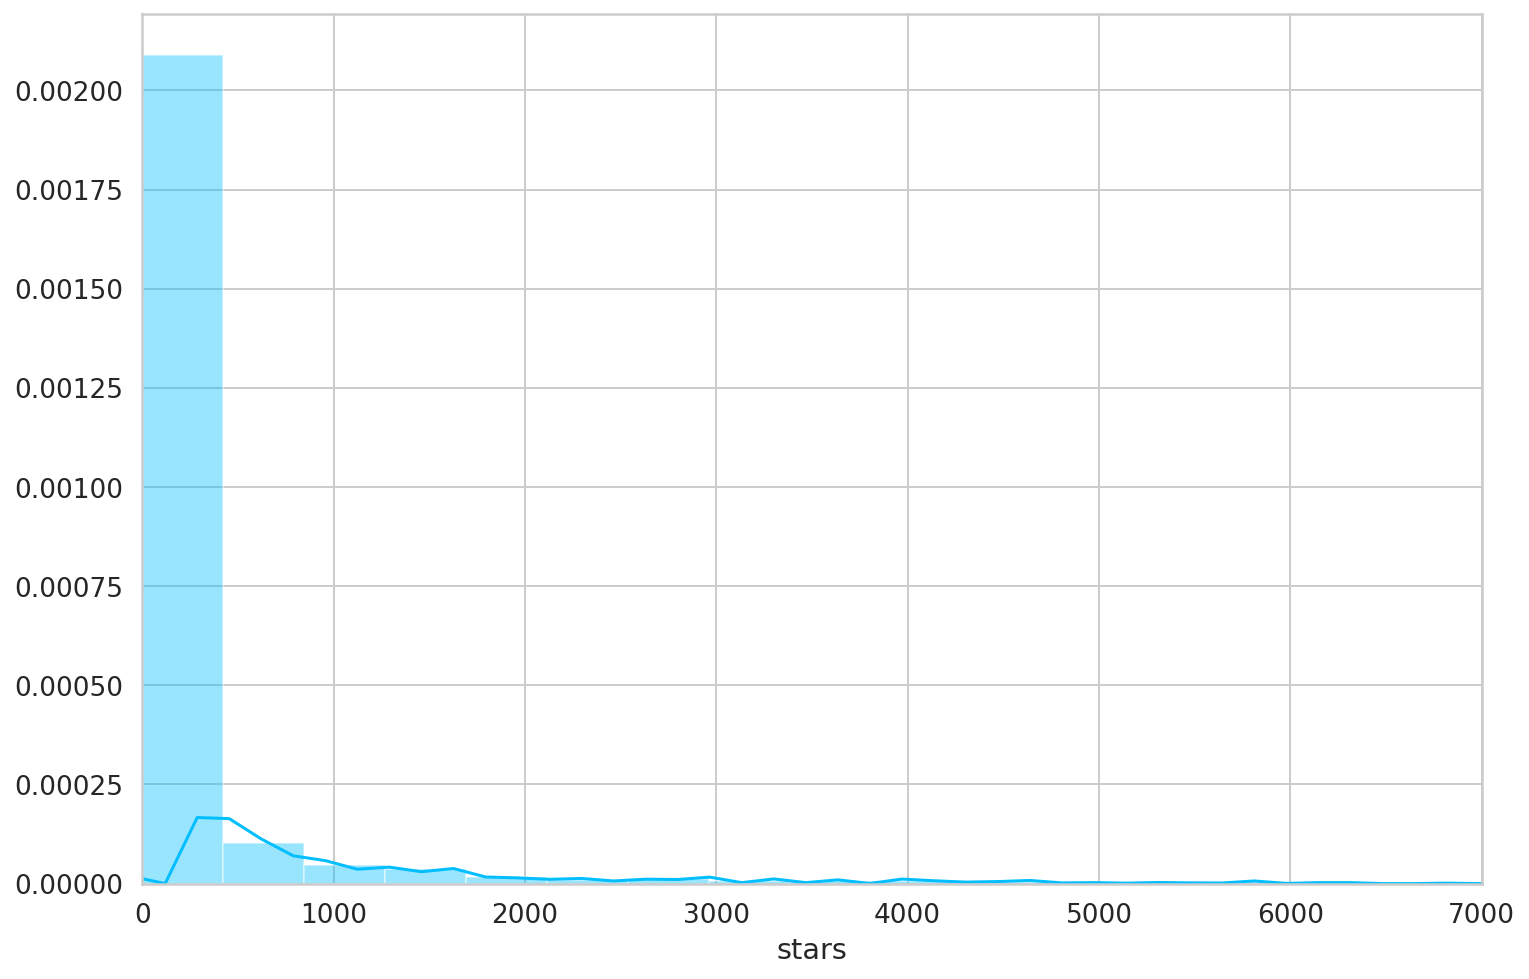

In [14]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
sns.distplot(repo_df['stars'])

plt.xlim([0, 7000])
plt.xlabel('stars')

In [15]:
# sns.distplot(repo_df['stars'], kde=False, norm_hist=True, bins=int(50))
# plt.xlim([0, 7000])
# plt.xlabel('stars')

In [16]:
repo_df.shape

(4993, 10)

In [17]:
repo_df[repo_df['stars'] > 600]

,forks,downloads,stars,release_counts,commits,issues,closedIssues,contributors,readme,contributor_count
repo,,,,,,,,,,
1adrianb/face-alignment,443,0,2225,10,84,0,0,"{bdvllrs, Serega6678, 1adrianb, kstanleyadams,...",5612,8
4paradigm/OpenMLDB,0,2941,1146,13,0,0,0,{},13438,0
AIStream-Peelout/flow-forecast,147,0,890,29,2769,122,72,"{wwymak, michaelwang1994, codeananda, kritim13...",5622,6
ARM-software/ComputeLibrary,180,30750,716,28,14,0,0,{mdigiorgio},10058,1
Angel-ML/angel,258,2733,995,19,448,0,0,"{rachelsunrh, paynie, jonaschn, howiehywang, l...",7396,8
...,...,...,...,...,...,...,...,...,...,...
zhaipro/easy12306,180,0,622,3,3,6,5,{},970,0
zhanghang1989/PyTorch-Encoding,188,0,757,7,35,0,0,{},3765,0
zhanghang1989/ResNeSt,0,9562,2336,6,31,122,78,{zhanghang1989},7250,1


In [18]:
repo_df['600stars']= np.where(repo_df['stars'] > 600, 1, 0)

In [19]:
repo_df['600stars'].value_counts()

0    4526
1     467
Name: 600stars, dtype: int64

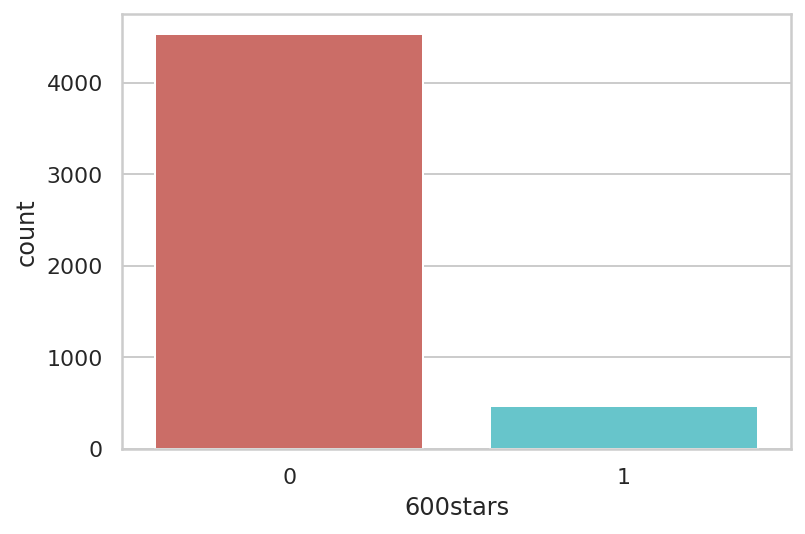

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='600stars',data=repo_df, palette='hls')
plt.show()
plt.savefig('count_plot')

In [21]:
repo_df.nlargest(n=10, columns=['stars'])

,forks,downloads,stars,release_counts,commits,issues,closedIssues,contributors,readme,contributor_count,600stars
repo,,,,,,,,,,,
opencv/opencv,21739,1305397,21169,57,4095,0,0,"{kyshel, m-gupta, utibenkei, Bleach665, sturkm...",844,236,1
ultralytics/yolov5,7412,14935514,20046,7,1852,0,0,"{jakepoz, lorenzomammana, Borda, glenn-jocher,...",14590,15,1
iperov/DeepFaceLab,4088,74760,18870,2,416,0,0,{iperov},6462,1,1
TencentARC/GFPGAN,2833,115997,17388,5,64,154,65,{xinntao},10898,1,1
d2l-ai/d2l-zh,3551,12209,15469,14,1013,0,0,"{astonzhang, goldmermaid, xyw5vplus1, xiaoting...",5314,7,1
ageitgey/face_recognition,4107,453,13956,2,61,0,0,"{ageitgey, ariyapour, snyk-bot, mtrsk, timgate...",17036,6,1
JaidedAI/EasyOCR,1830,1139155,13657,15,457,0,0,"{AlexKuhnle, abdullahselek, aaaaaa, wannaphong...",11047,58,1
tesseract-ocr/tesseract,1985,0,13338,20,1568,0,0,"{1480c1, juliangilbey, M3ssman, Robyer, xloem,...",8314,23,1
deepfakes/faceswap,3104,360175,13028,3,465,0,0,"{daniellivingston, geewiz94, torzdf}",12719,3,1


In [22]:
new_df.nsmallest(n=5, columns=['stars'])

,repo,release_tag,release_date,downloads,stars,forks,commits,issues,closedIssues,readme,readme_size,contributors
1,100/Solid,0.1,2017-06-19T07:03:57Z,0,0,0,0,0,0,# Metaheuristics-library-placeholder\n\n## Cur...,1767,[]
3,10up/classifai,1.1.0,2019-03-21T16:35:45Z,0,0,0,0,0,0,## Klasifai\n\nClassify WordPress Content usin...,2839,[]
4,10up/classifai,1.2.0,2019-03-21T16:39:03Z,0,0,0,0,0,0,# ![ClassifAI](https://cldup.com/zn3_j2A-DL.pn...,4826,[]
5,10up/classifai,1.2.1,2019-04-26T21:06:20Z,0,0,1,0,0,0,# ![ClassifAI](https://cldup.com/zn3_j2A-DL.pn...,4881,[]
6,10up/classifai,1.3.0,2019-06-07T21:44:38Z,0,0,0,0,0,0,# ![ClassifAI](https://classifaiplugin.com/wp-...,7618,[]


In [23]:
# has_download_repos.sort_values(by=['release_counts'], ascending=False)

In [24]:
repo_df.groupby('600stars').mean()

,forks,downloads,stars,release_counts,commits,issues,closedIssues,readme,contributor_count
600stars,,,,,,,,,
0,9.601193,10241.627707,68.718294,7.482324,124.324348,7.399912,5.372072,6281.549271,1.998232
1,481.306210,57889.190578,2369.109208,21.794433,652.910064,19.503212,14.152034,11486.445396,9.051392


# Logistic Regression

In [25]:
cols=['forks', 'downloads', 'stars', 'commits', 'issues',
      'closedIssues', 'contributor_count', 'readme','release_counts']
X=repo_df[cols]
y=repo_df['600stars']
# X,y

In [26]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.299453
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               600stars   No. Observations:                 4993
Model:                          Logit   Df Residuals:                     4984
Method:                           MLE   Df Model:                            8
Date:                Thu, 07 Jul 2022   Pseudo R-squ.:                 0.03599
Time:                        10:17:41   Log-Likelihood:                -1495.2
converged:                       True   LL-Null:                       -1551.0
Covariance Type:            nonrobust   LLR p-value:                 1.757e-20
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
forks                 0.0012      0.001      0.851      0.395      -0.002       0.004
download

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/users/kent/jmaharja/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/users/kent/jmaharja/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
y_pred = logreg.predict(X_test)

In [29]:
X_test.shape

(1498, 9)

In [30]:
y_test.value_counts()

0    1349
1     149
Name: 600stars, dtype: int64

In [31]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.89



# Validation

In [32]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

/users/kent/jmaharja/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/users/kent/jmaharja/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/users/kent/jmaharja/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/users/kent/jmaharja/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/users/kent/jmaharja/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will

10-fold cross validation average accuracy: 0.951


/users/kent/jmaharja/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/users/kent/jmaharja/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/users/kent/jmaharja/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1230  119]
 [  39  110]]


In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1349
           1       0.48      0.74      0.58       149

    accuracy                           0.89      1498
   macro avg       0.72      0.83      0.76      1498
weighted avg       0.92      0.89      0.90      1498



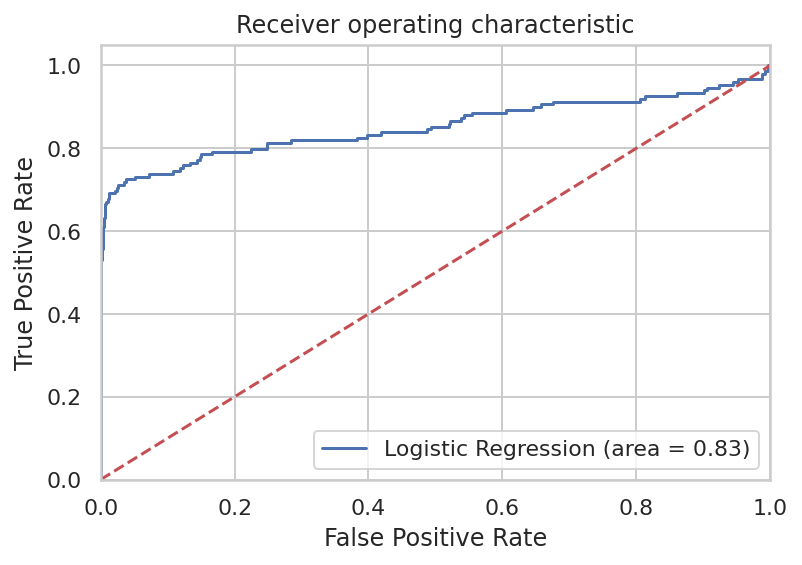

In [35]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

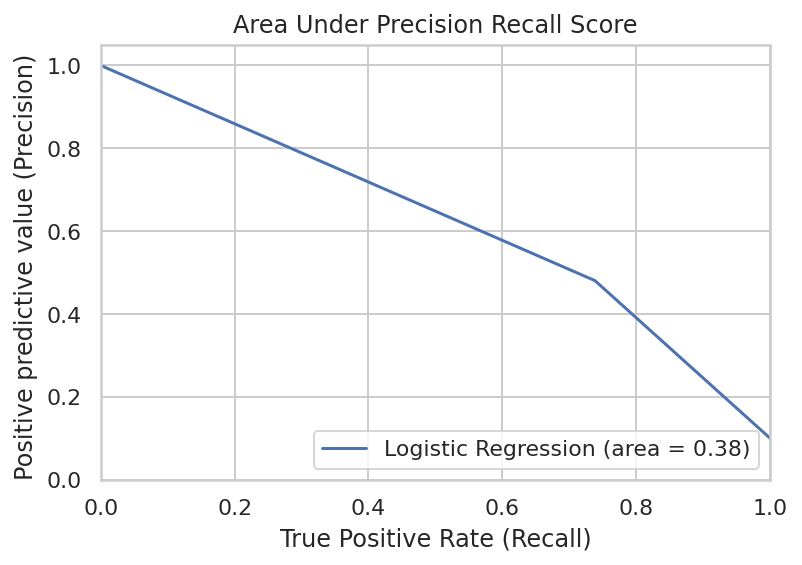

In [53]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
auprc = average_precision_score(y_test, logreg.predict(X_test))
precision, recall, thresholds = precision_recall_curve( y_test, logreg.predict(X_test))
plt.figure()
plt.plot(recall, precision, label='Logistic Regression (area = %0.2f)' % auprc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('True Positive Rate (Recall)')
plt.ylabel('Positive predictive value (Precision) ')
plt.title('Area Under Precision Recall Score')
plt.legend(loc="lower right")
plt.savefig('Log_AUPRC')
plt.show()

In [49]:
#  Compute Precision-Recall and plot curve
from sklearn.metrics import auc

precision, recall, thresholds = precision_recall_curve(y_test, logreg.predict_proba(X_test)[:,1])
area = auc(recall, precision)
print ("Area Under PR Curve(AP): %0.2f" % area,  "#should be same as AP?")

print ('AP', average_precision_score(y_test, y_pred, average='weighted'))
print ('AP', average_precision_score(y_test, y_pred, average='macro'))
print ('AP', average_precision_score(y_test, y_pred, average='micro'))
print ('AP', average_precision_score(y_test, y_pred, average='samples'))

Area Under PR Curve(AP): 0.76 #should be same as AP?
AP 0.38065503474656226
AP 0.38065503474656226
AP 0.38065503474656226
AP 0.38065503474656226


In [40]:
from sklearn.metrics import PrecisionRecallDisplay

display = precision_recall_curve(
    modelCV, X_test, y_test, name="LinearSVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

ImportError: cannot import name 'PrecisionRecallDisplay'

# SHAP Analysis

In [37]:
import shap

In [38]:
# Fits the explainer
explainer = shap.Explainer(logreg.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

KeyboardInterrupt: 

In [ ]:
# Evaluate SHAP values
# shap_values = explainer.shap_values(X)

In [ ]:
shap.plots.bar(shap_values)


In [ ]:
# shap.summary_plot(shap_values)
# or 
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.bar(shap_values[0])

In [ ]:
# shap.plots.force(shap_test[0])

# XGBoost with Skikit-Learn

In [ ]:
import xgboost as xgb
cols=['forks', 'downloads', 'release_counts', 'commits', 'issues', 'closedIssues'] 
X=repo_df[cols]
y=repo_df['1kstars']

In [ ]:
# xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
# xgb_model.fit(X, y)

# y_pred = xgb_model.predict(X)

# print(confusion_matrix(y, y_pred))

In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

xgb.plot_importance(xgb_model)

# plot the output tree via matplotlib, specifying the ordinal number of the target tree
# xgb.plot_tree(xgb_model, num_trees=xgb_model.best_iteration)

# converts the target tree to a graphviz instance
xgb.to_graphviz(xgb_model, num_trees=xgb_model.best_iteration)

In [ ]:

from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt

In [ ]:
# fig, ax = plt.subplots(figsize=(30, 30))
# plot_tree(xgb_model, num_trees=0, rankdir='LR')
# plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))

plot_tree(xgb_model, num_trees=4, ax=ax)

plt.show()
plt.savefig("tree.pdf")

